## Transformer 模型详解(选听)
- Attention
- Transformer Encoder
- Transformer Decoder

### 项目信息
- hubgging hub : https://huggingface.co/
- Transformer : https://github.com/huggingface/transformers

### Attention

Attetion 论文地址：https://arxiv.org/abs/1706.03762

NLP 神经网络模型的本质就是对输入文本进行编码，常规的做法是首先对句子进行分词，然后将每个词语 (token) 都转化为对应的词向量 (token embeddings)，
这样文本就转换为一个由词语向量组成的矩阵$X=(x_1,x_2,...,x_n)$，其中$x_i$就表示第$i$个词语的词向量，维度为$d$，故 $X \in R^{n*d}$。

在 Transformer 模型提出之前，对 token 序列 $X$ 的常规编码方式是通过循环网络 (RNNs) 和卷积网络 (CNNs)。
- RNN（例如 LSTM）的方案很简单，每一个词语$x_t$对应的编码结果$y_t$通过递归地计算得到：
$$y_t=f(y_{t-1},x_t)$$
缺点：RNN 的序列建模方式虽然与人类阅读类似，但是递归的结构导致其无法并行计算，因此速度较慢。而且 RNN 本质是一个马尔科夫决策过程，难以学习到全局的结构信息；

- CNN 则通过滑动窗口基于局部上下文来编码文本，例如核尺寸为 3 的卷积操作就是使用每一个词自身以及前一个和后一个词来生成嵌入式表示：
$$y_t=f(x_{t-1},x_t,x_{t+1})$$

缺点：CNN 能够并行地计算，因此速度很快，但是由于是通过窗口来进行编码，所以更侧重于捕获局部信息，难以建模长距离的语义依赖。


**Google《Attention is All You Need》** 提供了第三个方案：直接使用 Attention 机制编码整个文本。相比 RNN 要逐步递归才能获得全局信息（因此一般使用双向 RNN），

而 CNN 实际只能获取局部信息，需要通过层叠来增大感受野，Attention 机制一步到位获取了全局信息：

$$y_t=f(x_t,A,B)$$

其中 $A,B$是另外的词语序列（矩阵），如果取 $A=B=X$就称为 Self-Attention，即直接将$x_t$与自身序列中的每个词语进行比较，最后算出$y_t$。

#### Scaled Dot-product Attention
本文以Scaled Dot-product Attention的实现为例。

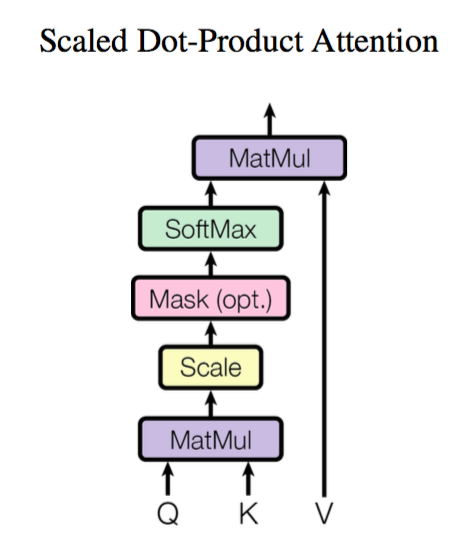

Scaled Dot-product Attention 共包含 2 个主要步骤：
- 1、计算注意力权重：使用某种相似度函数度量每一个 query 向量和所有 key 向量之间的关联程度。对于长度为$m$的Query序列和长度为$n$的 Key 序列，该步骤会生成一个尺寸为$m*n$的注意力分数矩阵。

特别地，Scaled Dot-product Attention 使用点积作为相似度函数，这样相似的 queries 和 keys 会具有较大的点积。

由于点积可以产生任意大的数字，这会破坏训练过程的稳定性。因此注意力分数还需要乘以一个缩放因子来标准化它们的方差，然后用一个 softmax 标准化。

这样就得到了最终的注意力权重$w_{ij}$，表示第$i$个 query 向量与第 $j$个 key 向量之间的关联程度。

- 2、更新 token embeddings：将权重$w_{ij}$与对应的 value 向量 $v_1,...,v_n$相乘以获得第 $i$个 query 向量更新后的语义表示 $x_i^{\prime}=\sum{j}w_{ij}v_j$。

因此整体可以表示为：

$$Attention(Q,K,V)=softmax(\frac{QK^T}{\sqrt{d_k}})V$$

其中 $Q \in R^{n*d_k},K \in R^{n*d_k},V \in R^{n*d_v}$分别是 query、key、value 向量序列。

如果忽略 softmax 激活函数，实际上它就是三个 $m*d_k,d_k*n,n*d_v$矩阵相乘，

得到一个 $m*d_v$的矩阵，也就是将 $m*d_k$ 的序列 $Q$编码成了一个新的 $m*d_v$的序列。

拆开来看更加清楚：

$$Attention(q_t,K,V)=\sum_{s=1}^{m}\frac{1}{Z}exp(\frac{\langle q_t,k_s \rangle}{\sqrt{d_k}})v_s$$

其中 $Z$是归一化因子，$K,V$是一一对应的 key 和 value 向量序列，Scaled Dot-product Attention 就是通过 $q_t$这个 query 与各个 $k_s$内积并 softmax 的方式来得到 $q_t$与各个$v_s$ 的相似度，

然后加权求和，得到一个 $d_v$维的向量。其中因子 $\sqrt{d_k}$起到调节作用，使得内积不至于太大。

注意！当$Q$和$K$ 序列相同时，注意力机制会为上下文中的相同单词分配非常大的分数（点积为 1），而在实践中，相关词往往比相同词更重要。

因此，多头注意力 (Multi-head Attention) 出现了！


#### Multi-head Attention
Multi-head Attention 首先通过线性映射将 $Q,K,V$序列映射到特征空间，每一组线性投影后的向量表示称为一个头 (head)，然后在每组映射后的序列上再应用 Scaled Dot-product Attention：

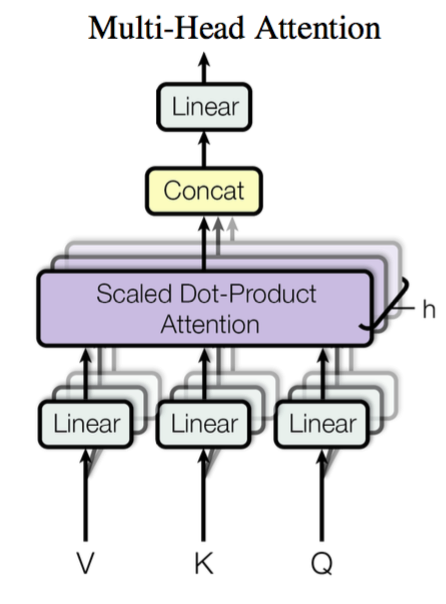

每个注意力头负责关注某一方面的语义相似性，多个头就可以让模型同时关注多个方面。因此与简单的 Scaled Dot-product Attention 相比，Multi-head Attention 可以捕获到更加复杂的特征信息。

形式化表示为：
$$head_i=Attetnion(QW_i^Q,KW_i^K,VW_i^V)$$

$$MutiHead(Q,K,V)=Concat(head_1,...,head_h)$$

其中$W_i^Q \in R^{d_k*\vec{d}_k},W_i^K \in R^{d_k*\vec{d}_k},W_i^V \in R^{d_v*\vec{d}_v}$是映射矩阵，是注意力头的数量。最后将多头的结果拼接起来就得到最终 $m*{d\vec{d}_v}$的结果序列。

所谓的“多头” (Multi-head)，其实就是多做几次 Scaled Dot-product Attention，然后把结果拼接。



### Transformer Encoder
回忆一下上一章中介绍过的标准 Transformer 结构，Encoder 负责将输入的词语序列转换为词向量序列，Decoder 则基于 Encoder 的隐状态来迭代地生成词语序列作为输出，每次生成一个词语
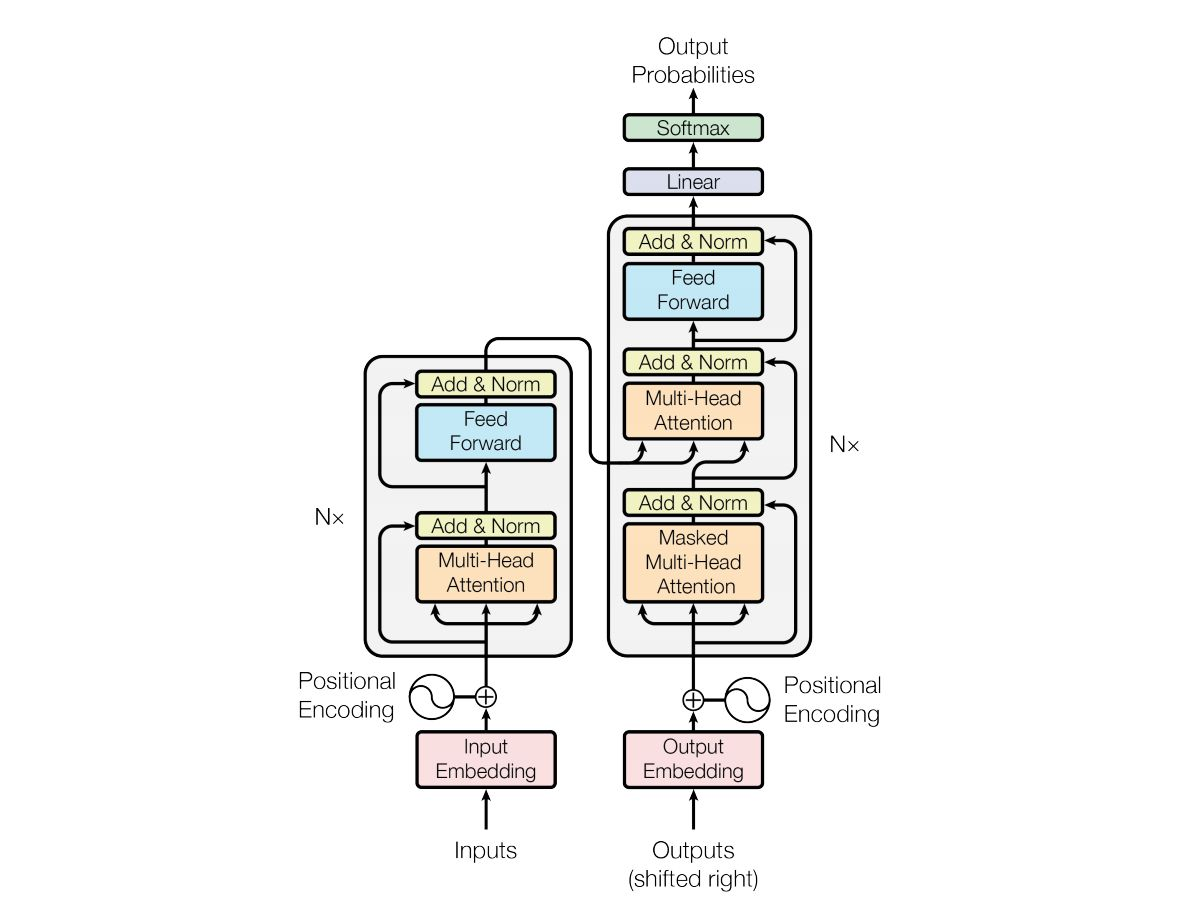

其中，Encoder 和 Decoder 都各自包含有多个 building blocks。下图展示了一个翻译任务的例子：

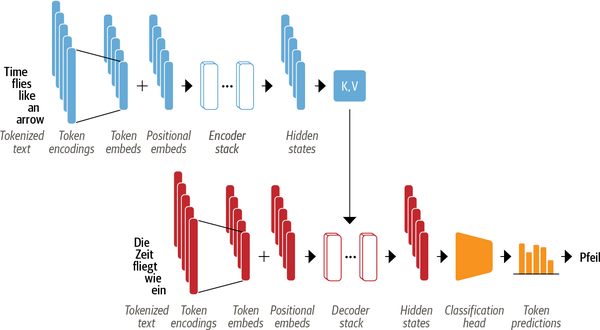

可以看到：
- 输入的词语首先被转换为词向量。由于注意力机制无法捕获词语之间的位置关系，因此还通过 positional embeddings 向输入中添加位置信息；
- Encoder 由一堆 encoder layers (blocks) 组成，类似于图像领域中的堆叠卷积层。同样地，在 Decoder 中也包含有堆叠的 decoder layers；
- Encoder 的输出被送入到 Decoder 层中以预测概率最大的下一个词，然后当前的词语序列又被送回到 Decoder 中以继续生成下一个词，重复直至出现序列结束符 EOS 或者超过最大输出长度。

#### The Feed-Forward Layer
Transformer Encoder/Decoder 中的前馈子层实际上就是两层全连接神经网络，它单独地处理序列中的每一个词向量，也被称为 position-wise feed-forward layer。

常见做法是让第一层的维度是词向量大小的 4 倍，然后以 GELU 作为激活函数。

#### Layer Normalization

Layer Normalization 负责将一批 (batch) 输入中的每一个都标准化为均值为零且具有单位方差；

Skip Connections 则是将张量直接传递给模型的下一层而不进行处理，并将其添加到处理后的张量中。

向 Transformer Encoder/Decoder 中添加 Layer Normalization 目前共有两种做法：

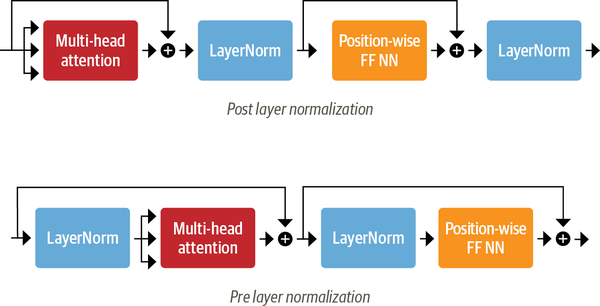

- Post layer normalization：Transformer 论文中使用的方式，将 Layer normalization 放在 Skip Connections 之间。 但是因为梯度可能会发散，这种做法很难训练，还需要结合学习率预热 (learning rate warm-up) 等技巧；
- Pre layer normalization：目前主流的做法，将 Layer Normalization 放置于 Skip Connections 的范围内。这种做法通常训练过程会更加稳定，并且不需要任何学习率预热。

相关：https://zhuanlan.zhihu.com/p/492803886

#### Positional Embeddings
前面讲过，由于注意力机制无法捕获词语之间的位置信息，因此 Transformer 模型还使用 Positional Embeddings 添加了词语的位置信息。

Positional Embeddings 基于一个简单但有效的想法：使用与位置相关的值模式来增强词向量。

如果预训练数据集足够大，那么最简单的方法就是让模型自动学习位置嵌入

Positional Embeddings 还有一些替代方案：

- **绝对位置表示**：使用由调制的正弦和余弦信号组成的静态模式来编码位置。 当没有大量训练数据可用时，这种方法尤其有效；

- **相对位置表示**：在生成某个词语的词向量时，一般距离它近的词语更为重要，因此也有工作采用相对位置编码。因为每个词语的相对嵌入会根据序列的位置而变化，这需要在模型层面对注意力机制进行修改，而不是通过引入嵌入层来完成，例如 DeBERTa 等模型。

### Transformer Decoder

Transformer Decoder 与 Encoder 最大的不同在于 Decoder 有两个注意力子层，如下图所示：

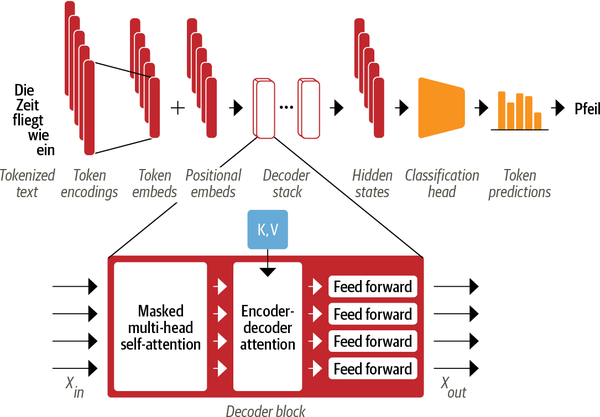

**Masked multi-head self-attention layer**：确保在每个时间步生成的词语仅基于过去的输出和当前预测的词，否则 Decoder 相当于作弊了；

**Encoder-decoder attention laye**r：以解码器的中间表示作为 queries，对 encoder stack 的输出 key 和 value 向量执行 Multi-head Attention。

通过这种方式，Encoder-Decoder Attention Layer 就可以学习到如何关联来自两个不同序列的词语，例如两种不同的语言。 解码器可以访问每个 block 中 Encoder 的 keys 和 values。

### Transformer 源码参考

https://gist.github.com/jsksxs360/3ae3b176352fa78a4fca39fff0ffe648

## 参考：
- https://zhuanlan.zhihu.com/p/448852278
- https://transformers.run/back/transformer/